# Spectrum Quality Prediction

In this vignette, we will use Depthcharge to predict the "quality" of a tandem mass spectrum; that is, the likelihood that a each tandem mass spectrum will be identified during a database search.
To do so, we will download a subset of files that were used to construct MassIVE-KB using PPX and perform a database search against the human proteome with Sage. 
Spectra that are matched to a peptide below 1% FDR will be labeled as high-quality, wereas spectra that failed to be matched will be annotated as low-quality for the purposes of our classifier.

This vignette is intended to run on Google Colab using a GPU instance.

## Install Dependencies

First we install PPX, Depthcharge and Polars, which we'll use in these analyses:

In [1]:
%%bash
pip install --upgrade polars lightning seaborn torchmetrics ppx xgboost scikit-learn depthcharge-ms

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.4/53.4 kB 658.5 kB/s eta 0:00:00 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 12.6 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: lightning
    Found existing installation: lightning 2.2.3
    Uninstalling lightning-2.2.3:
      Successfully uninstalled lightning-2.2.3


In [2]:
!cp "../../data/spectrum-quality/splits.json" ./splits.json

## Load Libraries

Now we load all of the libraries we'll need to generate our datasets, train a model, and plot our results.

In [3]:
import json
from pathlib import Path

import torch
import torch.nn as nn
import torch.nn.functional as F
import polars as pl
import ppx
import depthcharge as dc
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import lightning as L

from depthcharge.data import SpectrumDataset
from depthcharge.transformers import SpectrumTransformerEncoder
from depthcharge.feedforward import FeedForward
from ppx import MassiveProject
from torch.utils.data import DataLoader
from lightning.pytorch import LightningModule, Trainer
from lightning.pytorch.loggers import CSVLogger
from torchmetrics.classification import BinaryAUROC
from lance.sampler import ShardedBatchSampler
from xgboost import XGBClassifier

Path("logs").mkdir(exist_ok=True)
Path("data/mzml").mkdir(parents=True, exist_ok=True)
ppx.set_data_dir("../../data/mzml")

L.pytorch.utilities.disable_possible_user_warnings()

## Create Our Datasets

We'll now download a random subset of mzML files used to create MassIVE-KB, and search them using Sage. 
The spectra identified by Sage at 1% FDR will be our positive examples, whereas the rest will be our negative examples.

First we select random files for our train, test, and validation splits from the subset of MassIVE-KB from high-resolution instruments with HCD fragmentation: 

In [4]:
with Path("splits.json").open("r") as buf:
    remote_files = json.load(buf)

search_results = {}
for split in ("train", "valid", "test"):
    search_results[split] = Path(
       f"../../data/spectrum-quality/{split}/results.sage.parquet"
    )

In [5]:
mzml_files = {}
for split, split_files in remote_files.items():
    mzml_files[split] = []
    for acc, fname in split_files:
        proj = MassiveProject(acc)
        loc = proj.local_files(fname)
        if not loc:
            loc = proj.download(fname)

        mzml_files[split].append(loc[0])

Finally, we can assemble our Depthcharge datasets for training and validation. However, we'll wait to assemble our test set until the very end, after all model training has been performed.

In [24]:
datasets = {}
samples = 0
for split, batch_size in [("train", 32), ("valid", 128)]:
    print(f"Creating the {split} dataset...")
    label_df = (
        pl.scan_parquet(search_results[split])
        .filter(pl.col("spectrum_q") <= 0.01)
        .select("filename", "scannr")
        .rename({"filename": "peak_file", "scannr": "scan_id"})
        .with_columns(pl.lit(True).alias("label"))
        .collect()
    )

    dataset_path = Path(f"/scratch/{split}.lance")
    if dataset_path.exists():
        datsets[split] = SpectrumDatset.form_lance(
            path=dataset_path,
            batch_size=batch_size,
            samples=samples,
        )
    else:
        datasets[split] = SpectrumDataset(
            mzml_files[split],
            batch_size=batch_size,
            path=dataset_path,
            samples=samples,
            parse_kwargs={"metadata_df": label_df},
        )

Creating the train dataset...


3B10-1.mzML:   0%|          | 0/26981 [00:00<?, ? spectra/s]

CHPP_97H_RP10_1.mzML:   0%|          | 0/21803 [00:00<?, ? spectra/s]

97H-10-R1.mzML:   0%|          | 0/46702 [00:00<?, ? spectra/s]

20150115_QE3_UPLC9_DBJ_SA_Waters_70frac_no_concatenation_rep1_10.mzML:   0%|          | 0/21802 [00:00<?, ? sp…

HeLa_ArgC-LysC_HCD_1.mzML:   0%|          | 0/59892 [00:00<?, ? spectra/s]

bladder_T_1_10.mzML:   0%|          | 0/48818 [00:00<?, ? spectra/s]

01524_A01_P015424_S00_N01_R1.mzML:   0%|          | 0/45583 [00:00<?, ? spectra/s]

SPHPP_UPV_CCD18_QE_GEL_R1_1_15.mzML:   0%|          | 0/73898 [00:00<?, ? spectra/s]

SPHPP_UPV_JURKAT_QE_CHAPS_RPB_R1_10_10.mzML:   0%|          | 0/70039 [00:00<?, ? spectra/s]

SPHPP_CIB_RAMOS_OTV_GEL_R1_10_15.mzML:   0%|          | 0/29986 [00:00<?, ? spectra/s]

Creating the valid dataset...


HF02_180507_XP_HCT_Trpsin_0-10_3ul_F1_R1.mzML:   0%|          | 0/71561 [00:00<?, ? spectra/s]

4817_HF01_XP_CHPP_Has_SDS10_10_5ul_60ms_AGC2E4.mzML:   0%|          | 0/48513 [00:00<?, ? spectra/s]

20181120_HCT116_P&amp;ACN_down_10.mzML:   0%|          | 0/71514 [00:00<?, ? spectra/s]

placenta_C18_1_F10.mzML:   0%|          | 0/65485 [00:00<?, ? spectra/s]

QE-000444_CTRL_PRM_02.mzML:   0%|          | 0/37753 [00:00<?, ? spectra/s]

## Create a Transformer Model

We will train a Transformer encoder model to predict the "quality" of each mass spectrum. 
Here, we create a PyTorch Lightning module using modules from Depthcharge to build our complete model.
For the loss function, we will use binary cross-entropy loss and we'll use Adam as our optimizer.

In [79]:
class SpectrumClassifier(SpectrumTransformerEncoder, L.LightningModule):
    """A model for clssifying mass spectra by quality."""
    def __init__(self, *args, **kwargs):
        """Initialize the model."""
        super().__init__(*args, **kwargs)
        self.mz_encoder = dc.encoders.FloatEncoder(self.d_model)
        self.charge_encoder = dc.encoders.FloatEncoder(self.d_model, 1, 10)
        self.head = nn.Sequential(nn.Linear(self.d_model, 1), nn.Sigmoid())
        #(self.d_model, 1, layers=1, append=nn.Sigmoid())
        self.auroc = BinaryAUROC()

    def global_token_hook(self, mz_array, precursor_mz, precursor_charge, *args, **kwargs):
        """Use our cls token"""
        mz_emb = self.mz_encoder(precursor_mz[:, None])
        charge_emb = self.charge_encoder(precursor_charge.type_as(mz_array)[:, None])
        return (mz_emb + charge_emb).squeeze()

    def step(self, batch, step_type):
        """A single step"""
        Y = batch["label"].type_as(batch["mz_array"])
        Y_hat = self.head(self(**batch)[0][:, 0, :]).flatten()
        loss = F.binary_cross_entropy(Y_hat, Y)
        self.log(f"{step_type}_loss", loss.item(), on_step=True, on_epoch=True, prog_bar=True, logger=True)
        if step_type == "valid":
            self.auroc(Y_hat, Y)
            self.log(f"{step_type}_auroc", self.auroc, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        return loss
    
    def training_step(self, batch, batch_idx):
        """The training step."""
        return self.step(batch, "train")

    def validation_step(self, batch, batch_idx):
        """The validation step."""
        return self.step(batch, "valid")

    def predict_step(self, batch, batch_idx):
        """The predict step."""
        return self.head(self(**batch)[0][:, 0, :]).flatten()

    def configure_optimizers(self):
        """Configure optimizers for training."""
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-4)
        return optimizer

## Fit Our Model

In [ ]:
datasets["train"].samples = 0
datasets["train"].batch_size = 32

datasets["valid"].samples = 50000
datasets["valid"].batch_size = 1024

train_loader = DataLoader(datasets["train"], batch_size=None)
valid_loader = DataLoader(datasets["valid"], batch_size=None)
logger = CSVLogger("logs", "model", version=0)
trainer = L.Trainer(
    max_epochs=20, 
    logger=logger,
    val_check_interval=1000,
)

model = SpectrumClassifier(d_model=512, nhead=16, n_layers=1, peak_encoder=enc)
trainer.fit(model, train_loader, valid_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type               | Params
-----------------------------------------------------------
0 | peak_encoder        | PeakEncoder        | 524 K 
1 | transformer_encoder | TransformerEncoder | 2.1 M 
2 | mz_encoder          | FloatEncoder       | 0     
3 | charge_encoder      | FloatEncoder       | 0     
4 | head                | Sequential         | 513   
5 | auroc               | BinaryAUROC        | 0     
-----------------------------------------------------------
2.6 M     Trainable params
0         Non-trainable params
2.6 M     Total params
10.510    Total estimated model params size (MB)


Sanity Checking: |                                               | 0/? [00:00<?, ?it/s]

Training: |                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                    | 0/? [00:00<?, ?it/s]

shape: (5, 4)
┌───────┬──────┬─────────────────┬──────────┐
│ epoch ┆ step ┆ metric          ┆ value    │
│ ---   ┆ ---  ┆ ---             ┆ ---      │
│ i64   ┆ i64  ┆ str             ┆ f64      │
╞═══════╪══════╪═════════════════╪══════════╡
│ 0     ┆ 49   ┆ train_loss_step ┆ 0.646227 │
│ 0     ┆ 99   ┆ train_loss_step ┆ 0.683652 │
│ 0     ┆ 149  ┆ train_loss_step ┆ 0.683109 │
│ 0     ┆ 199  ┆ train_loss_step ┆ 0.76331  │
│ 0     ┆ 249  ┆ train_loss_step ┆ 0.678829 │
└───────┴──────┴─────────────────┴──────────┘
shape: (129, 4)
┌───────┬──────┬─────────────────┬──────────┐
│ epoch ┆ step ┆ metric          ┆ value    │
│ ---   ┆ ---  ┆ ---             ┆ ---      │
│ i64   ┆ i64  ┆ str             ┆ f64      │
╞═══════╪══════╪═════════════════╪══════════╡
│ 0     ┆ 49   ┆ train_loss_step ┆ 0.646227 │
│ 0     ┆ 99   ┆ train_loss_step ┆ 0.683652 │
│ 0     ┆ 149  ┆ train_loss_step ┆ 0.683109 │
│ 0     ┆ 199  ┆ train_loss_step ┆ 0.76331  │
│ 0     ┆ 249  ┆ train_loss_step ┆ 0.678829 │
│ … 

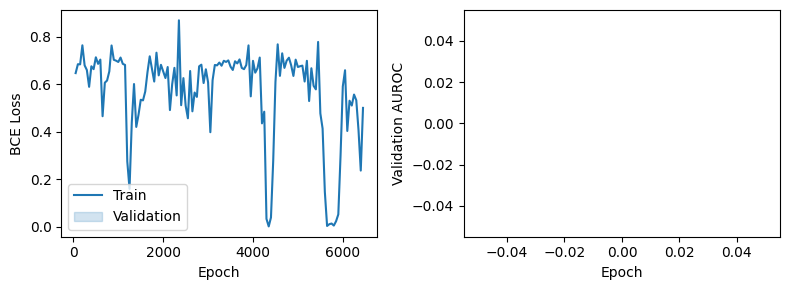

In [62]:
metrics = (
    pl.read_csv("logs/model/version_0/metrics.csv")
    .melt(["epoch", "step"], variable_name="metric")
    .drop_nulls()
)

print(metrics.head())


losses = metrics.filter(pl.col("metric").str.contains("_loss_step"))
print(losses)
auroc = metrics.filter(pl.col("metric") == "valid_auroc")

fig, axs = plt.subplots(1, 2, figsize=(8, 3))
sns.lineplot(data=losses, x="step", y="value", hue="metric", ax=axs[0])
axs[0].set_ylabel("BCE Loss")
axs[0].set_xlabel("Epoch")
axs[0].legend(labels=["Train", "Validation"])

sns.lineplot(data=auroc, x="epoch", y="value", ax=axs[1])
axs[1].set_ylabel("Validation AUROC")
axs[1].set_xlabel("Epoch")

plt.tight_layout()
plt.show()

## Create a baseline model

In [46]:
n_bins = 100
max_mz = 2000
min_mz = 140

def bin_spectra(batch, n_bins=100, min_mz=140, max_mz=2000):
    """Bin mass spectra.

    Parameters
    ----------
    batch : dict of torch.Tensor
        The batch of data.
    n_bins : int
        The number of bins.
    min_mz : float
        The lowest m/z bin.
    max_mz : float
        The highest m/z bin.
   
    Returns
    -------
    torch.Tensor
        The batch of binned mass spectra.
    """
    bins = torch.linspace(min_mz, max_mz, n_bins - 1)
    out = torch.empty(batch["mz_array"].shape[0], n_bins)
    binned = torch.bucketize(batch["mz_array"], bins)
    for i in range(out.shape[0]):
        out[i, :] = torch.bincount(
            binned[i, :], 
            weights=batch["intensity_array"][i, :], 
            minlength=n_bins,
        )

    return out


X_train, y_train = zip(*[(bin_spectra(b), b["label"]) for b in train_loader])
X_train = torch.vstack(X_train).detach().cpu().numpy()
y_train = torch.cat(y_train).detach().cpu().numpy()

xgb = XGBClassifier().fit(X_train, y_train)

## Evaluate the Models

In [47]:
X_test, y_test = zip(*[(bin_spectra(b), b["label"]) for b in valid_loader])
X_test = torch.vstack(X_test).detach().cpu().numpy()
y_test = torch.cat(y_test).detach().cpu().numpy()

baseline = xgb.predict_proba(X_test)[:, 1]

In [63]:
pred = trainer.predict(model, valid_loader)
pred = torch.cat(pred).detach().cpu().numpy()

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |                                                    | 0/? [00:00<?, ?it/s]

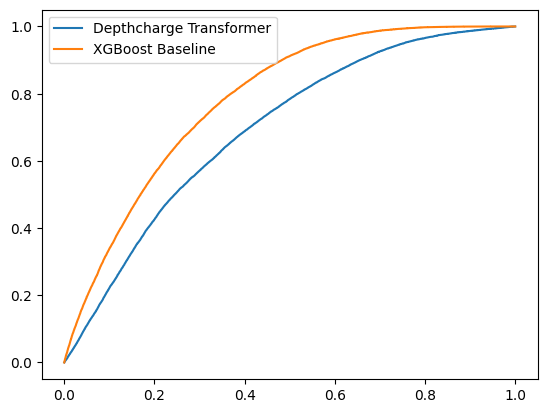

In [64]:
baseline_fpr, baseline_tpr, _ = sklearn.metrics.roc_curve(y_test, baseline)
pred_fpr, pred_tpr, _ = sklearn.metrics.roc_curve(y_test, pred)

plt.figure()
plt.step(pred_fpr, pred_tpr, where="pre", label="Depthcharge Transformer")
plt.step(baseline_fpr, baseline_tpr, where="pre", label="XGBoost Baseline")
plt.legend()
plt.show()